<a href="https://colab.research.google.com/github/datascience-uniandes/classification_tutorial/blob/master/churn/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification: Detecting churn probability and causes

MINE-4101: Applied Data Science  
Univerisdad de los Andes  
  
Last update: October, 2023

In [1]:
!pip show shap

Name: shap
Version: 0.46.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: 
Author: 
Author-email: Scott Lundberg <slund1@cs.washington.edu>
License: MIT License
Location: /usr/local/lib/python3.10/dist-packages
Requires: cloudpickle, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm
Required-by: 


In [2]:
from joblib import dump

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

#from pandas_profiling import ProfileReport

import shap

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

### Loading the data

In [4]:
churn_df = pd.read_csv("https://raw.githubusercontent.com/amrios80/a-b-testing-tutorial/refs/heads/Master/data/churn_train_val.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/amrios80/a-b-testing-tutorial/refs/heads/Master/data/churn_test_labeled.csv")

In [5]:
churn_df.shape

(9000, 11)

In [6]:
test_df.shape

(1000, 11)

In [7]:
churn_df.dtypes

,0
credit_score,int64
country,object
gender,object
age,int64
tenure,int64
balance,float64
products_number,int64
credit_card,int64
active_member,int64
estimated_salary,float64


In [8]:
churn_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,781,Spain,Male,35,1,0.00,2,0,0,42117.90,0
1,701,Spain,Female,21,9,0.00,2,1,1,26327.42,0
2,685,Spain,Female,25,10,128509.63,1,1,0,121562.33,0
3,680,France,Male,34,3,143292.95,1,1,0,66526.01,0
4,756,Germany,Female,34,2,148200.72,1,0,0,194584.48,0


In [9]:
test_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,713,Spain,Female,48,1,163760.82,1,0,0,157381.14,1
1,502,France,Male,30,4,0.00,2,1,1,66263.87,0
2,817,Germany,Male,45,9,101207.75,1,0,0,88211.12,1
3,730,France,Male,39,1,116537.60,1,0,0,145679.60,0
4,576,Spain,Male,52,2,100549.43,2,1,1,16644.16,0


### Profiling the data

In [10]:
#profile = ProfileReport(churn_df)

In [11]:
#profile.to_notebook_iframe()

### Analyzing relationships between features and target

In [12]:
churn_df["churn"].value_counts(dropna=False, normalize=True)

,proportion
churn,
0,0.796333
1,0.203667


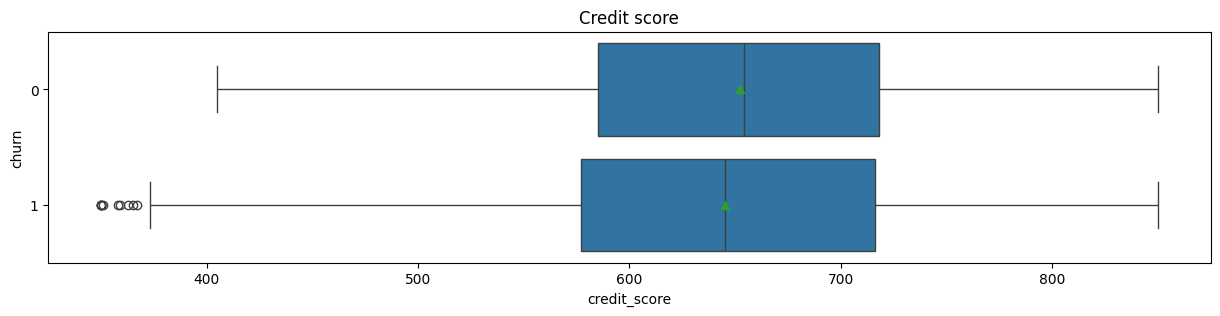

In [13]:
plt.figure(figsize=(15, 3))
sns.boxplot(data=churn_df, x="credit_score", y="churn", showmeans=True, orient="h")
plt.title("Credit score")
plt.show()

In [14]:
pd.crosstab(churn_df["churn"], churn_df["country"], normalize="columns")

country,France,Germany,Spain
churn,,,
0,0.838083,0.67593,0.831847
1,0.161917,0.32407,0.168153


In [15]:
pd.crosstab(churn_df["churn"], churn_df["gender"], normalize="columns")

gender,Female,Male
churn,,
0,0.748541,0.836538
1,0.251459,0.163462


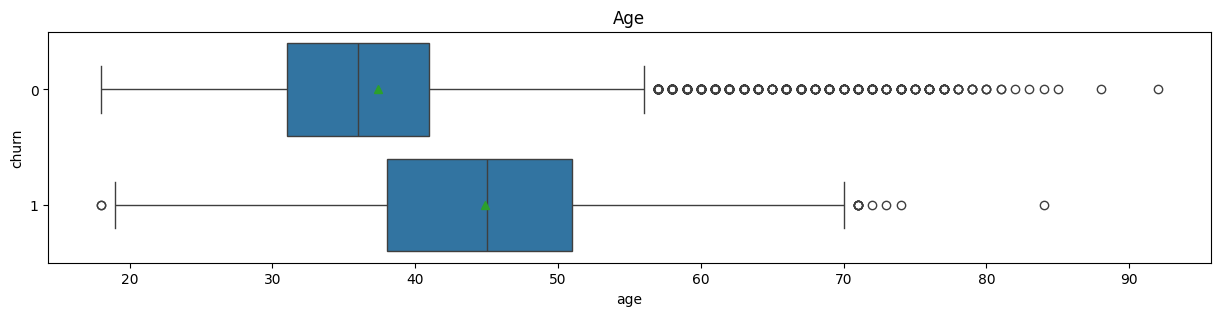

In [16]:
plt.figure(figsize=(15, 3))
sns.boxplot(data=churn_df, x="age", y="churn", showmeans=True, orient="h")
plt.title("Age")
plt.show()

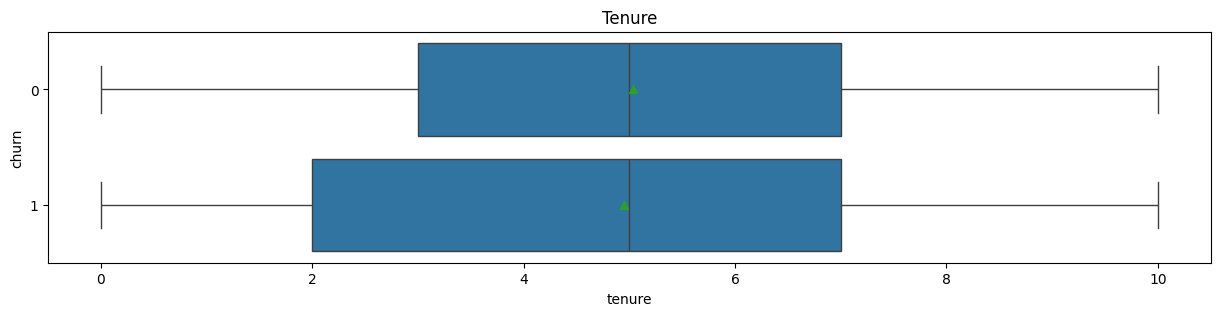

In [17]:
plt.figure(figsize=(15, 3))
sns.boxplot(data=churn_df, x="tenure", y="churn", showmeans=True, orient="h")
plt.title("Tenure")
plt.show()

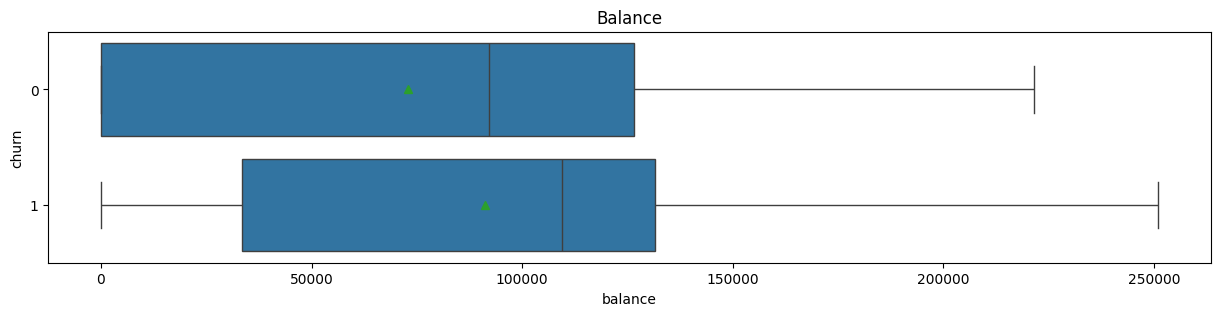

In [18]:
plt.figure(figsize=(15, 3))
sns.boxplot(data=churn_df, x="balance", y="churn", showmeans=True, orient="h")
plt.title("Balance")
plt.show()

In [19]:
pd.crosstab(churn_df["churn"], churn_df["products_number"], normalize="columns")

products_number,1,2,3,4
churn,,,,
0,0.723349,0.922965,0.167382,0.0
1,0.276651,0.077035,0.832618,1.0


In [20]:
pd.crosstab(churn_df["churn"], churn_df["credit_card"], normalize="columns")

credit_card,0,1
churn,,
0,0.79414,0.797255
1,0.20586,0.202745


In [21]:
pd.crosstab(churn_df["churn"], churn_df["active_member"], normalize="columns")

active_member,0,1
churn,,
0,0.73243,0.85622
1,0.26757,0.14378


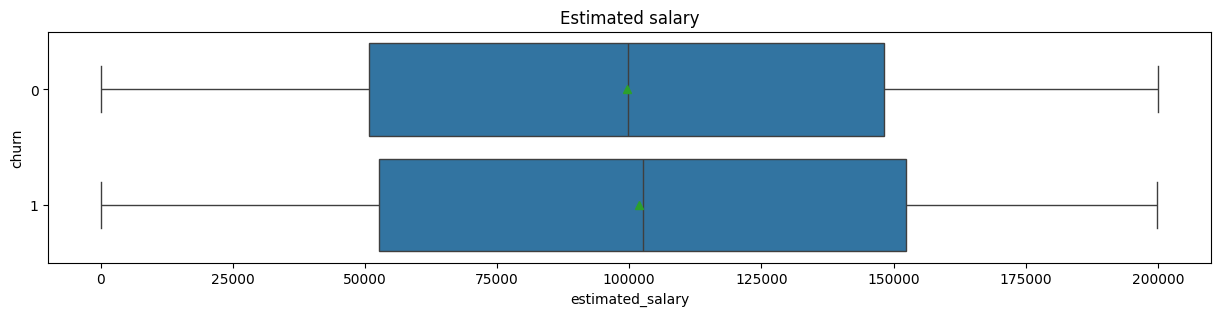

In [22]:
plt.figure(figsize=(15, 3))
sns.boxplot(data=churn_df, x="estimated_salary", showmeans=True, y="churn", orient="h")
plt.title("Estimated salary")
plt.show()

### Quantifying the relationships

In [23]:
numerical_features = ["credit_score", "age", "tenure", "balance", "estimated_salary"]

In [24]:
ks_results = []
for f in numerical_features:
    ks_stat, p_value = ks_2samp(churn_df.loc[churn_df["churn"] == 1, f], churn_df.loc[churn_df["churn"] == 0, f])
    ks_results.append({
        "Feature": f,
        "KS stat": ks_stat,
        "p-value": p_value
    })
pd.DataFrame(ks_results)

,Feature,KS stat,p-value
0,credit_score,0.041854,1.162424e-02
1,age,0.391306,1.280784e-200
2,tenure,0.016615,8.074933e-01
3,balance,0.149778,4.916898e-29
4,estimated_salary,0.026711,2.435241e-01


- A high KS statistic (and a small p-value) indicates that the distributions of the feature are significantly different between the two classes. This suggests that the feature might be discriminative and useful for classification.
- Conversely, a low KS statistic (and a large p-value) suggests that the feature has a similar distribution across both classes and may not be as informative.

In [25]:
categorical_features = ["country", "gender", "products_number", "credit_card", "active_member"]

In [26]:
chi2_results = []
for f in categorical_features:
    onehot = OneHotEncoder(sparse_output=False)
    t = onehot.fit_transform(churn_df[[f]])
    values = onehot.categories_[0]
    chi2_stats, p_values = chi2(t, churn_df["churn"])

    for value, chi_stat, p_value in zip(values, chi2_stats, p_values):
        chi2_results.append({
            "Feature": f,
            "Value": value,
            "Chi2 stat": chi_stat,
            "p-value": p_value
        })
pd.DataFrame(chi2_results)

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

- A feature with a high χ² value and a low p-value is considered to be more relevant for the classification task because it has a significant association with the target variable. Such a feature can potentially improve the performance of a classifier.
- Conversely, a feature with a low χ² value and a high p-value might not be very informative for the classification task, as it doesn't seem to have a strong relationship with the target variable.

### Training a first set of models and selecting the best using F1

In [ ]:
features = ["age", "balance", "country", "products_number", "active_member"]

In [ ]:
pipeline = Pipeline([
    ("transformer", ColumnTransformer([
        ("categorical", OneHotEncoder(sparse_output=False), ["country"])
    ], remainder="passthrough")),
    ("classifier",  RandomForestClassifier(random_state=10))
])

In [ ]:
param_grid = {
    "classifier__n_estimators": [50, 100, 150],
    "classifier__max_depth" : [3, 4, 5, 6],
    "classifier__class_weight": ["balanced", None]
}

In [ ]:
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)

In [ ]:
grid.fit(churn_df[features], churn_df["churn"])

In [ ]:
grid.best_params_

In [ ]:
best_results_df = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_].reset_index().rename(columns={"index": "result", grid.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

In [ ]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [ ]:
train_val_preds = grid.best_estimator_.predict(churn_df[features])
test_preds = grid.best_estimator_.predict(test_df[features])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df["churn"], train_val_preds, labels=grid.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["churn"], test_preds, labels=grid.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(churn_df["churn"], train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(test_df["churn"], test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [ ]:
print("Precision:")
print("- Train/Val:", precision_score(churn_df["churn"], train_val_preds))
print("- Test:", precision_score(test_df["churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df["churn"], train_val_preds))
print("- Test:", recall_score(test_df["churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df["churn"], train_val_preds))
print("- Test:", f1_score(test_df["churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df["churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["churn"], test_preds))

In [ ]:
test_probs = grid.best_estimator_.predict_proba(test_df[features])[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), test_df["churn"].values.reshape(-1, 1), axis=1), columns=["probs", "true"])

In [ ]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

### Exporting the pipeline

In [ ]:
dump(grid.best_estimator_, "./churn-v1.0.joblib")

### Explaining predictions

In [ ]:
test_df["prob"] = test_probs

In [ ]:
test_df.sort_values(by="prob").head()

In [ ]:
test_df.sort_values(by="prob", ascending=False).head()

In [ ]:
test_df.loc[(test_df["prob"] > 0.47) & (test_df["prob"] < 0.53)].head()

In [ ]:
X_t = pd.DataFrame(
    grid.best_estimator_["transformer"].fit_transform(test_df[features]),
    columns=[f.split("__")[1] for f in grid.best_estimator_["transformer"].get_feature_names_out()]
)

In [ ]:
def model(X):
    return grid.best_estimator_["classifier"].predict_proba(X)[:,1]

explainer = shap.Explainer(model, X_t)
shap_values = explainer(X_t)

**Explaining individual predictions:**

In [ ]:
shap.plots.waterfall(shap_values[837])

In [ ]:
shap.plots.waterfall(shap_values[148])

In [ ]:
shap.plots.waterfall(shap_values[4])

In [ ]:
shap.plots.waterfall(shap_values[7])

**Explaining all instances:**

In [ ]:
shap.summary_plot(shap_values, plot_type="violin")